<a href="https://colab.research.google.com/github/rahultrada/National_DS_Bowl/blob/main/densenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip '/content/drive/My Drive/Colab Notebooks/Applied ML/AML 2/datasciencebowl/train.zip'

Streaming output truncated to the last 5000 lines.
  inflating: train/trichodesmium_puff/110182.jpg  
  inflating: train/trichodesmium_puff/110212.jpg  
  inflating: train/trichodesmium_puff/110253.jpg  
  inflating: train/trichodesmium_puff/110463.jpg  
  inflating: train/trichodesmium_puff/110493.jpg  
  inflating: train/trichodesmium_puff/110545.jpg  
  inflating: train/trichodesmium_puff/110562.jpg  
  inflating: train/trichodesmium_puff/11076.jpg  
  inflating: train/trichodesmium_puff/110777.jpg  
  inflating: train/trichodesmium_puff/110808.jpg  
  inflating: train/trichodesmium_puff/110836.jpg  
  inflating: train/trichodesmium_puff/111004.jpg  
  inflating: train/trichodesmium_puff/111043.jpg  
  inflating: train/trichodesmium_puff/111178.jpg  
  inflating: train/trichodesmium_puff/111289.jpg  
  inflating: train/trichodesmium_puff/111345.jpg  
  inflating: train/trichodesmium_puff/111417.jpg  
  inflating: train/trichodesmium_puff/111435.jpg  
  inflating: train/trichodesmium

In [ ]:
#Invert image color
from PIL import Image, ImageOps
import torchvision.transforms.functional as FF


class Invert(object):
    """Inverts the color channels of an PIL Image
    while leaving intact the alpha channel.
    """
    
    def invert(self, img):
        r"""Invert the input PIL Image.
        Args:
            img (PIL Image): Image to be inverted.
        Returns:
            PIL Image: Inverted image.
        """
        if not FF._is_pil_image(img):
            raise TypeError('img should be PIL Image. Got {}'.format(type(img)))

        if img.mode == 'RGBA':
            r, g, b, a = img.split()
            rgb = Image.merge('RGB', (r, g, b))
            inv = ImageOps.invert(rgb)
            r, g, b = inv.split()
            inv = Image.merge('RGBA', (r, g, b, a))
        elif img.mode == 'LA':
            l, a = img.split()
            l = ImageOps.invert(l)
            inv = Image.merge('LA', (l, a))
        else:
            inv = ImageOps.invert(img)
        return inv

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to be inverted.
        Returns:
            PIL Image: Inverted image.
        """
        return self.invert(img)

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [ ]:
# def make_weights_for_balanced_classes(images, nclasses):                        
#     count = [0] * nclasses                                                      
#     for item in images:                                                         
#         count[int(item[1])] += 1                                                     
#     weight_per_class = [0.] * nclasses                                      
#     N = float(sum(count))                                                   
#     for i in range(nclasses):                                                   
#         weight_per_class[i] = N/float(count[i])                                 
#     weight = [0] * len(images)                                              
#     for idx, val in enumerate(images):                                          
#         weight[idx] = weight_per_class[int(val[1])]                                  
#     return weight

In [ ]:
# #weighted random sampling!
# from torch.utils.data.sampler import SubsetRandomSampler, WeightedRandomSampler
# from sklearn.model_selection import train_test_split
# data_dir = '/content/train'
# mean, std =[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
# train_transforms = transforms.Compose([transforms.Resize([224,224],interpolation=2),
#                                         Invert(),
#                                         transforms.RandomRotation((0,90)),
#                                         transforms.RandomVerticalFlip(0.5),
#                                         transforms.RandomHorizontalFlip(0.5),
#                                         transforms.ToTensor(),
#                                         transforms.Normalize(mean,std)])
# valid_transforms = transforms.Compose([transforms.Resize([224,224],interpolation=2),
#                                         Invert(),
#                                         transforms.ToTensor(),
#                                         transforms.Normalize(mean,std)])

# traindataset0 = datasets.ImageFolder(data_dir, transform=train_transforms)
# validdataset0 = datasets.ImageFolder(data_dir, transform=valid_transforms)
# targets = traindataset0.targets
# train_idx, valid_idx = train_test_split(np.arange(len(targets)), test_size=0.1, random_state=42, shuffle=True, stratify=targets)
# train_dataset = torch.utils.data.Subset(traindataset0, train_idx)
# valid_dataset = torch.utils.data.Subset(validdataset0, valid_idx)

# np_train_idx = np.array(train_idx)
# trainimages = np.array(traindataset0.imgs)[np_train_idx]
# weights = torch.Tensor(make_weights_for_balanced_classes(trainimages, 121))

# train_sampler = WeightedRandomSampler(weights, len(weights), replacement=True)
# trainloader = torch.utils.data.DataLoader(train_dataset, sampler=train_sampler, batch_size=64)
# validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=64)

In [ ]:
# #make augmented copies of images in classes with 100 or fewer original images
# from google.colab.patches import cv2_imshow
# import cv2 
# import os
# from PIL import Image
# image_size = 128
# root = '/content/train'
# stop = False
# for category in os.listdir(root):
#   path = os.path.join(root, category)
#   num_samples = len(os.listdir(path))
#   for i in os.listdir(path):
#     imgpath = path+'/'+i
#     img = cv2.imread(imgpath, 0)
#     img = cv2.resize(img,(image_size,image_size),interpolation=cv2.INTER_AREA)
#     if num_samples < 250:
#       img_pref = imgpath.split('.')[0]
#       # flip 
#       horizontal_img = cv2.flip(img, 0)
#       vertical_img = cv2.flip(img, 1)
#       both_img = cv2.flip(img, -1)
#       cv2.imwrite(img_pref+'_1'+'.jpg', horizontal_img)
#       cv2.imwrite(img_pref+'_2'+'.jpg', vertical_img)
#       cv2.imwrite(img_pref+'_3'+'.jpg', both_img)
#       # rotation 
#       (h, w) = img.shape[:2]
#       center = (w / 2, h / 2)
#       M = cv2.getRotationMatrix2D(center, 90, 1.0)
#       rotated90 = cv2.warpAffine(img, M, (h, w))
#       M = cv2.getRotationMatrix2D(center, 180, 1.0)
#       rotated180 = cv2.warpAffine(img, M, (h, w))
#       M = cv2.getRotationMatrix2D(center, 270, 1.0)
#       rotated270 = cv2.warpAffine(img, M, (h, w))
#       cv2.imwrite(img_pref+'_4'+'.jpg', rotated90)
#       cv2.imwrite(img_pref+'_5'+'.jpg', rotated180)
#       cv2.imwrite(img_pref+'_6'+'.jpg', rotated270)
#       # Gaussian filter
#       blur5 = cv2.GaussianBlur(img,(5,5),0)
#       blur10 = cv2.GaussianBlur(img,(7,7),0)
#       blur15 = cv2.GaussianBlur(img,(9,9),0)
#       blur20 = cv2.GaussianBlur(img,(13,13),0)
#       cv2.imwrite(img_pref+'_7'+'.jpg', blur5)
#       cv2.imwrite(img_pref+'_8'+'.jpg', blur10)
#       cv2.imwrite(img_pref+'_9'+'.jpg', blur15)
#       cv2.imwrite(img_pref+'_10'+'.jpg', blur20)

ERROR! Session/line number was not unique in database. History logging moved to new session 59


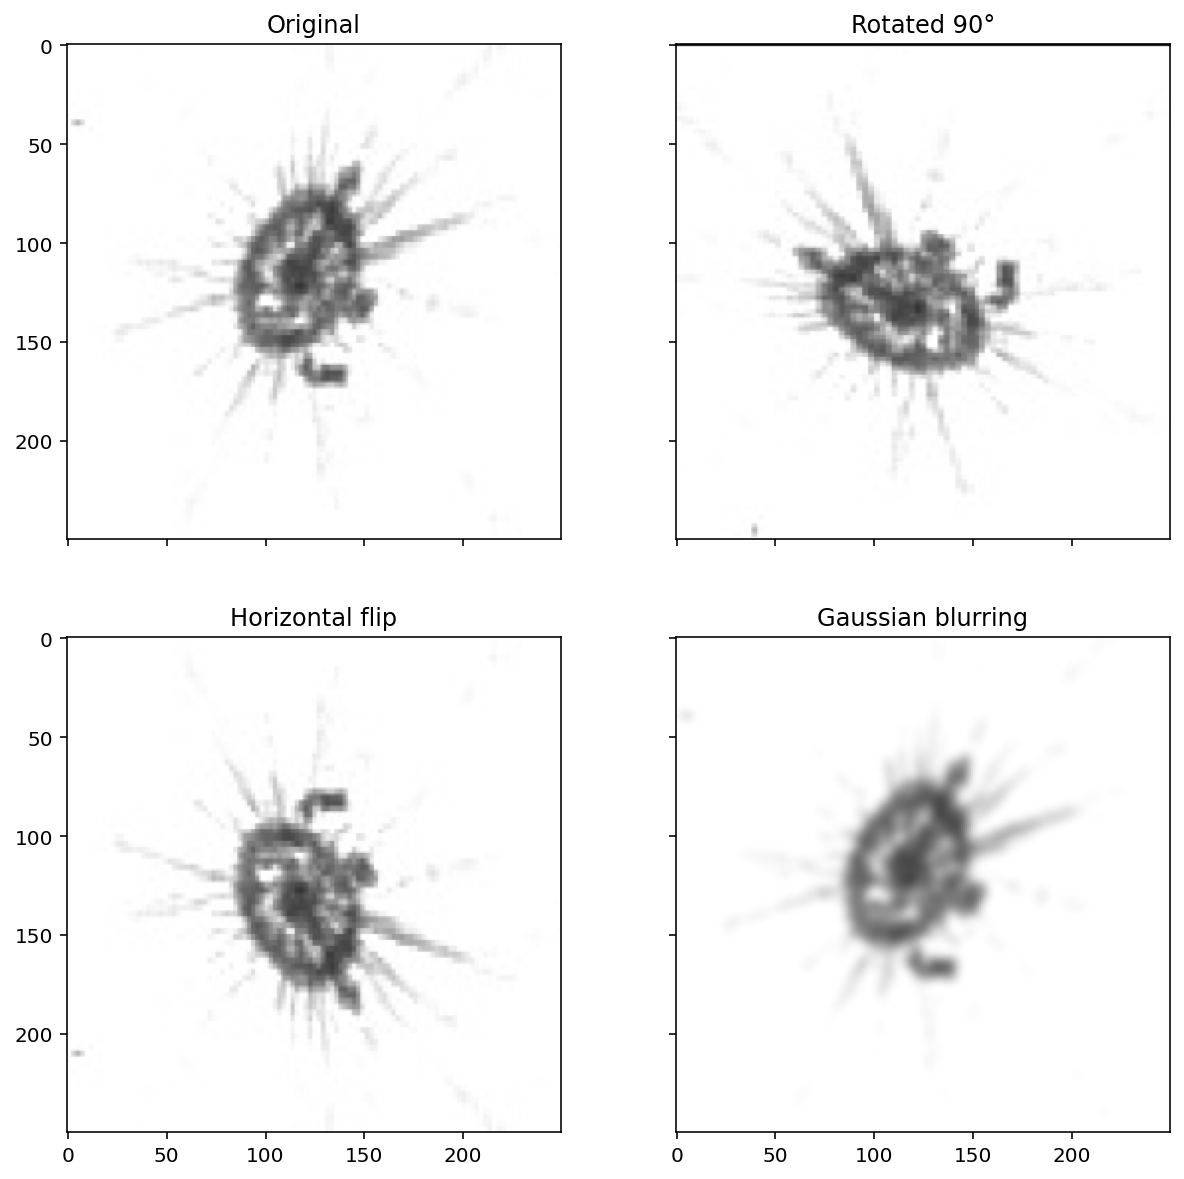

In [ ]:
from google.colab.patches import cv2_imshow
import cv2 
import os
from PIL import Image

#img = Image.open('/content/train/acantharia_protist_big_center/111204.jpg')
# a = Invert()
# inverted = a.invert(img)
# inverted.save('/content/train/acantharia_protist_big_center/rahul.jpg')
# imgcv2 = cv2.imread('/content/train/acantharia_protist_big_center/rahul.jpg')
# cv2_imshow(imgcv2)

img = cv2.imread('/content/train/acantharia_protist_big_center/55072.jpg')
img = cv2.resize(img,(250,250),interpolation=cv2.INTER_AREA)
(h, w) = img.shape[:2]
center = (w / 2, h / 2)
M = cv2.getRotationMatrix2D(center, 90, 1.0)
rotated90 = cv2.warpAffine(img, M, (h, w))

horizontal_img = cv2.flip(img, 0)

blur10 = cv2.GaussianBlur(img,(13,13),0)

# cv2_imshow(img)
# cv2_imshow(rotated90)
# cv2_imshow(horizontal_img)
# cv2_imshow(blur10)


f, axarr = plt.subplots(2, 2, figsize=(10,10))
axarr[0,0].imshow(img)
axarr[0, 0].set_title('Original')
axarr[0,1].imshow(rotated90)
axarr[0, 1].set_title('Rotated 90' + '\xb0')
axarr[1,0].imshow(horizontal_img)
axarr[1, 0].set_title('Horizontal flip')
axarr[1,1].imshow(blur10)
axarr[1, 1].set_title('Gaussian blurring')
# Fine-tune figure; hide x ticks for top plots and y ticks for right plots
plt.setp([a.get_xticklabels() for a in axarr[0, :]], visible=False)
plt.setp([a.get_yticklabels() for a in axarr[:, 1]], visible=False)
plt.savefig("augmentation.png")
plt.show()


In [ ]:
data_dir = '/content/train'
def load_split_train_valid(datadir, valid_size = .2, batchsize=512):
    mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
    train_transforms = transforms.Compose([transforms.Resize([224,224],interpolation=2),
                                           Invert(),
                                           transforms.RandomRotation(90),
                                           transforms.RandomVerticalFlip(),
                                           transforms.RandomHorizontalFlip(),
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean,std)])
    valid_transforms = transforms.Compose([transforms.Resize([224,224],interpolation=2),
                                           Invert(),
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean,std)])
    train_data = datasets.ImageFolder(datadir, transform=train_transforms)
    valid_data = datasets.ImageFolder(datadir, transform=valid_transforms)
    from torch.utils.data.sampler import SubsetRandomSampler
    from sklearn.model_selection import train_test_split
    targets = train_data.targets
    train_idx, valid_idx = train_test_split(np.arange(len(targets)), test_size=valid_size, random_state=42, shuffle=True, stratify=targets)
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=batchsize)
    validloader = torch.utils.data.DataLoader(valid_data,
                   sampler=valid_sampler, batch_size=batchsize)
    return trainloader, validloader

trainloader, validloader = load_split_train_valid(data_dir, .1, 64)

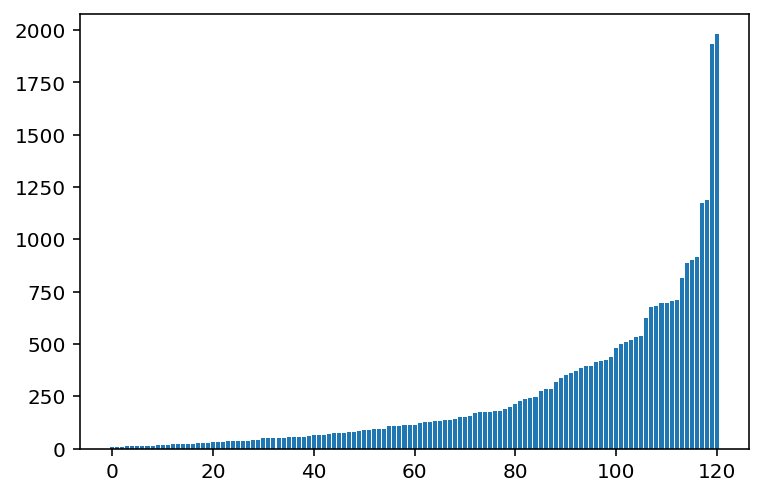

In [ ]:
def plot_class_distribution():
  dist = [0]*121
  for i in trainloader.dataset.imgs:
    dist[i[1]] += 1
  plt.bar(range(121),sorted(dist))
  plt.savefig('classdistr.png')

plot_class_distribution()

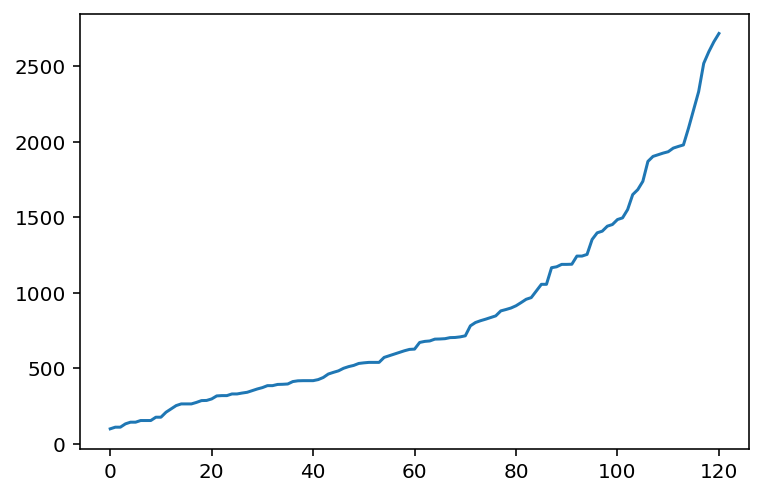

In [ ]:
plot_class_distribution()

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
model = []

In [ ]:
model = models.resnet50(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)
#model = models.densenet169(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# for param in model.parameters():
#     param.requires_grad = False
  
#resnet
# model.fc = nn.Sequential(nn.Linear(512, 256),
#                          nn.ReLU(),
#                          nn.Dropout(0.3),
#                          nn.Linear(256,121),
#                          nn.LogSoftmax(dim=1))

#densenet
model.classifier = nn.Sequential(nn.Linear(1664,512),
                                 nn.ReLU(),
                                 nn.Dropout(0.3),
                                 nn.Linear(512,121),
                                 nn.LogSoftmax(dim=1))
# model.classifier = nn.Sequential(nn.Linear(1664,121),
#                                  nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
model.to(device)
criterion.to(device)
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
def train(model, data_loader, optimizer, criterion):
    
    epoch_loss = 0
    model.train()
    
    for inputs, labels in data_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        
        output = model.forward(inputs)
        
        loss = criterion(output, labels)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(data_loader)

In [ ]:
def evaluate(model, data_loader, criterion):
    
    epoch_loss = 0
    
    model.eval()
    
    with torch.no_grad():
        for inputs, labels in data_loader:
          inputs, labels = inputs.to(device), labels.to(device)
    
          output = model.forward(inputs)
          loss = criterion(output, labels)

          epoch_loss += loss.item()
        
    return epoch_loss / len(data_loader)

In [ ]:
best_valid_loss = float('inf')
best_epoch = 0
train_losses = []
valid_losses = []
patience = 15 #how many epochs of increase in val loss to observe before stopping
verbose = True

for epoch in range(1000):
    start_time = time.time()
    
    train_loss = train(model, trainloader, optimizer, criterion)
    valid_loss = evaluate(model, validloader, criterion)
    
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_epoch = epoch
        torch.save(model.state_dict(), '/content/drive/My Drive/Colab Notebooks/Applied ML/AML 2/model.pt')
    
    if verbose:
      print(f'Epoch: {epoch:02} | Epoch Time: {epoch_mins}m {epoch_secs}s | {time.ctime()}')
      print(f'\tTrain Loss: {train_loss:.3f}')
      print(f'\t Val. Loss: {valid_loss:.3f}')

    if (epoch-best_epoch) > patience:
      print(f'Early stopping at epoch {epoch}')
      np.savetxt('/content/drive/My Drive/Colab Notebooks/Applied ML/AML 2/train_losses.txt', train_losses)
      np.savetxt('/content/drive/My Drive/Colab Notebooks/Applied ML/AML 2/valid_losses.txt', valid_losses)
      break

In [ ]:
rename saved model in drive

best valid loss: 0.7671433358142773, best epoch: 12


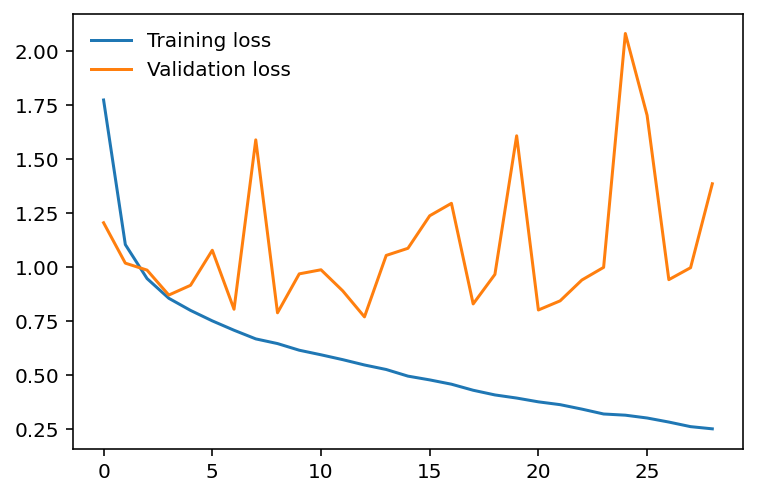

In [ ]:
print("best valid loss: {}, best epoch: {}".format(best_valid_loss, best_epoch))
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [ ]:
model.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/Applied ML/AML 2/densenet169_7.pt'))
model.eval();

In [ ]:
trainloss = evaluate(model, trainloader, criterion)
validloss = evaluate(model, validloader, criterion)
print(trainloss, validloss)

0.33183777222379307 0.33379799872636795


In [ ]:
#CELLS BELOW ARE TO EVALUATE SAVED MODEL ON TEST SET

In [ ]:
#LOAD SAVED MODEL
model.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/Applied ML/AML 2/.pt'))
model.eval();

In [ ]:
#calculate validation accuracy
accuracy = 0
with torch.no_grad():
  for inputs, labels in validloader:
    inputs, labels = inputs.to(device), labels.to(device)
    output = model.forward(inputs)
    output = torch.exp(output)
    top_p, top_class = output.topk(1, dim=1)
    equals = top_class == labels.view(*top_class.shape)
    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
print('Accuracy: ', accuracy/len(validloader))

Accuracy:  0.7429136621455351


In [ ]:
#unzip test data
!unzip '/content/drive/My Drive/Colab Notebooks/Applied ML/AML 2/datasciencebowl/test.zip'

Streaming output truncated to the last 5000 lines.
  inflating: test/94449.jpg          
  inflating: test/94450.jpg          
  inflating: test/94451.jpg          
  inflating: test/94452.jpg          
  inflating: test/94456.jpg          
  inflating: test/94457.jpg          
  inflating: test/94458.jpg          
  inflating: test/94459.jpg          
  inflating: test/9446.jpg           
  inflating: test/94461.jpg          
  inflating: test/94463.jpg          
  inflating: test/94464.jpg          
  inflating: test/94465.jpg          
  inflating: test/94467.jpg          
  inflating: test/94468.jpg          
  inflating: test/94469.jpg          
  inflating: test/9447.jpg           
  inflating: test/94470.jpg          
  inflating: test/94471.jpg          
  inflating: test/94472.jpg          
  inflating: test/94473.jpg          
  inflating: test/94474.jpg          
  inflating: test/94475.jpg          
  inflating: test/94476.jpg          
  inflating: test/94477.jpg          

In [ ]:
#create this class in order to get the testloader to return the image filepath when traversing through the testloader.
#we need the image names as the index column when submitting the csv to kaggle
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [ ]:
#LOAD TEST DATA
test_data_dir = '/content/test2' #NOTE: create a new folder on the left tab called 'test2' and move 'test' into it
mean, std =[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
#test transforms should be same as validation transforms
test_transforms = transforms.Compose([transforms.Resize([224,224],interpolation=2),
                                      #Invert(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean,std)])
#test_data = datasets.ImageFolder(test_data_dir, transform=test_transforms)
test_data = ImageFolderWithPaths(test_data_dir, transform=test_transforms)
testloader = torch.utils.data.DataLoader(test_data, 1024)

In [ ]:
#GENERATE TEST SET PREDICTIONS
indexes = []
numrows = len(testloader.dataset.imgs)
batchsize = testloader.batch_size
numbatches = len(testloader)
predictions = np.zeros((numrows, len(trainloader.dataset.classes)))
with torch.no_grad():
  idx1, idx2 = 0, batchsize
  print('num batches: ', numbatches)
  for i, (inputs, _, path) in enumerate(testloader):
    if i % np.round(numbatches/10) == 0:
      print('batch', i)
    indexes += list(path)
    inputs = inputs.to(device)
    output = model.forward(inputs)
    output = torch.exp(output)
    predictions[idx1:idx2,] = output.cpu().numpy()
    idx1 += batchsize
    #if it's going to be the last batch, set idx2 to the last index
    if i == numbatches-2:
      idx2 = numrows
    else:
      idx2 += batchsize

num batches:  128
batch 0
batch 13
batch 26
batch 39
batch 52
batch 65
batch 78
batch 91
batch 104
batch 117


In [ ]:
np.savetxt('/content/drive/My Drive/Saved models/predictions_densenet169_5.txt', predictions)

In [ ]:
#clean up indexes (only need the image name, not the entire path)
for i in range(len(indexes)):
  indexes[i] = indexes[i].split("/content/test2/test/")[1]

In [ ]:
#GENERATE SUBMISSION CSV
import pandas as pd
df = pd.DataFrame(predictions, columns=trainloader.dataset.classes, index=indexes)
df.index.name = 'image'
df.head()

,acantharia_protist,acantharia_protist_big_center,acantharia_protist_halo,amphipods,appendicularian_fritillaridae,appendicularian_s_shape,appendicularian_slight_curve,appendicularian_straight,artifacts,artifacts_edge,chaetognath_non_sagitta,chaetognath_other,chaetognath_sagitta,chordate_type1,copepod_calanoid,copepod_calanoid_eggs,copepod_calanoid_eucalanus,copepod_calanoid_flatheads,copepod_calanoid_frillyAntennae,copepod_calanoid_large,copepod_calanoid_large_side_antennatucked,copepod_calanoid_octomoms,copepod_calanoid_small_longantennae,copepod_cyclopoid_copilia,copepod_cyclopoid_oithona,copepod_cyclopoid_oithona_eggs,copepod_other,crustacean_other,ctenophore_cestid,ctenophore_cydippid_no_tentacles,ctenophore_cydippid_tentacles,ctenophore_lobate,decapods,detritus_blob,detritus_filamentous,detritus_other,diatom_chain_string,diatom_chain_tube,echinoderm_larva_pluteus_brittlestar,echinoderm_larva_pluteus_early,...,polychaete,protist_dark_center,protist_fuzzy_olive,protist_noctiluca,protist_other,protist_star,pteropod_butterfly,pteropod_theco_dev_seq,pteropod_triangle,radiolarian_chain,radiolarian_colony,shrimp-like_other,shrimp_caridean,shrimp_sergestidae,shrimp_zoea,siphonophore_calycophoran_abylidae,siphonophore_calycophoran_rocketship_adult,siphonophore_calycophoran_rocketship_young,siphonophore_calycophoran_sphaeronectes,siphonophore_calycophoran_sphaeronectes_stem,siphonophore_calycophoran_sphaeronectes_young,siphonophore_other_parts,siphonophore_partial,siphonophore_physonect,siphonophore_physonect_young,stomatopod,tornaria_acorn_worm_larvae,trichodesmium_bowtie,trichodesmium_multiple,trichodesmium_puff,trichodesmium_tuft,trochophore_larvae,tunicate_doliolid,tunicate_doliolid_nurse,tunicate_partial,tunicate_salp,tunicate_salp_chains,unknown_blobs_and_smudges,unknown_sticks,unknown_unclassified
image,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1.jpg,1.127156e-04,3.833213e-07,1.132905e-05,4.905690e-06,1.167774e-05,3.208210e-04,5.012420e-05,3.359092e-04,1.237262e-01,1.576917e-04,1.011709e-05,1.731798e-03,1.880776e-05,1.222956e-04,1.590780e-04,5.726424e-06,5.865287e-06,6.172212e-05,3.742024e-06,2.231328e-06,7.573221e-05,5.552051e-06,1.169960e-05,3.254899e-06,2.762260e-03,3.264198e-05,6.109683e-05,1.702600e-03,5.273840e-06,1.963392e-06,1.199929e-06,6.300024e-07,2.329031e-06,6.173240e-03,1.338067e-01,2.099329e-01,3.531529e-02,1.341985e-01,6.429641e-06,1.235319e-05,...,5.059620e-05,2.379463e-05,2.046753e-05,3.151092e-05,0.001354,2.865742e-05,3.723344e-05,3.391611e-07,8.643518e-06,3.739901e-03,1.296606e-04,2.307938e-05,1.905562e-06,9.307002e-06,1.480584e-05,3.866394e-06,1.943665e-06,4.663477e-06,5.800911e-07,2.190953e-06,2.038068e-06,6.097238e-07,3.207404e-07,6.335697e-06,4.993173e-05,1.320336e-06,1.356595e-06,2.851525e-05,3.179410e-05,2.245710e-04,3.475789e-03,1.172602e-06,7.883086e-05,3.019722e-05,1.291797e-06,1.125374e-05,8.017669e-06,0.086438,1.739424e-02,0.001155
10.jpg,8.302387e-05,1.008746e-06,2.909330e-07,2.689741e-07,2.184842e-08,1.600455e-06,1.779827e-06,3.835099e-06,1.027893e-05,1.541232e-05,2.235146e-06,2.267887e-04,3.807650e-06,6.689822e-07,7.886106e-03,1.546126e-04,1.090705e-06,6.307131e-03,8.288064e-06,5.281044e-05,4.570094e-06,8.512547e-06,1.049845e-05,9.482251e-08,5.541192e-01,4.136133e-01,2.570452e-05,3.831657e-05,1.450686e-06,3.878639e-07,4.061198e-07,4.986623e-06,1.037937e-07,1.377307e-04,1.310327e-04,1.477770e-02,7.085582e-06,8.476789e-06,5.523056e-07,1.615438e-05,...,2.827618e-07,1.035037e-05,5.072631e-07,6.423519e-06,0.000069,2.742207e-06,4.403962e-06,6.237036e-08,1.910612e-06,6.712785e-07,5.548504e-06,2.340916e-07,9.756087e-07,1.072805e-06,4.891915e-07,1.299890e-06,9.477446e-07,1.944787e-06,8.988299e-06,1.148469e-06,9.331670e-07,9.767961e-08,1.630116e-08,8.929845e-07,1.704790e-07,7.523761e-08,1.827769e-07,1.019110e-05,2.974291e-08,1.280016e-05,3.793660e-05,4.790210e-07,2.378253e-06,9.229103e-07,3.104749e-07,4.925996e-07,2.463720e-07,0.001514,6.741579e-05,0.000058
100.j

In [ ]:
#create a submission zip file, which can be manually downloaded from the left files tab
df.to_csv('submission.csv')
!zip submission.zip submission.csv

  adding: submission.csv (deflated 56%)
